In [1]:
import os
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, date
from scipy import stats

import pandapower as pp
import utils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from matplotlib import animation, rc
from IPython.display import HTML

import classes

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
system = classes.GridNetwork(os.path.join('inputs','greensboro.json'))

ingesting network info


In [3]:
# # save to thumbdrive
# simulations_dir = '../../../../../media/lndunn/datadrive/projects/gridsim/simulations/'

# save locally
simulations_dir = 'simulations/'

metadata = pd.read_csv(os.path.join(simulations_dir, 'metadata.csv'), index_col=0)

idx = (metadata['event_duration']==300)&(metadata['lambda_overhead'].round(6)==0.001712)&(metadata['lambda_underground'].round(6)==0.000856)
metadata = metadata[idx]

errors = []
metrics = pd.DataFrame(index=metadata.index, columns=['number','saidi','saifi','caidi','mwh'])
# for ii, ix in enumerate(metadata.index.tolist()):
for ii, ix in enumerate([304,]):
    if ii % 100 == 0:
        print ii
    number = metadata['number'].loc[ix]
    outages = pd.read_csv(os.path.join(simulations_dir, 'outage_tables', 'outages_simulation%i.csv'%(number)), index_col=0)
    
    n = 10
    newOutages = outages.copy()
    
    idx = pd.notnull(newOutages['customers'])
    newOutages = newOutages[idx]
    
    newOutages['end'] = np.nan
    time_steps = np.arange(outages['start'].min()-60, outages['end'].max()+60, 15)
    for t in time_steps:
        idx = (newOutages['start']<=t) & (pd.isnull(newOutages['end']))
        
        if sum(idx) <= n:
            to_fix = newOutages.loc[idx].index
        else:
            _idx = pd.isnull(newOutages['end'])&(newOutages['start']<=t)
            to_fix = newOutages[_idx].sort_values('load', ascending=False).iloc[:n].index
        
        print t, n, len(to_fix), sum((newOutages['end']>t) & (newOutages['end']<=t+15))
        if sum((newOutages['end']>t) & (newOutages['end']<=t+15)) > 10:
            print '\n', newOutages[(newOutages['end']>t) & (newOutages['end']<=t+15)], '\n'
            
        for l in to_fix:
            newOutages['end'].loc[l] = t + newOutages['repair_time'].loc[l]

        n -= len(to_fix)        
        n += sum((newOutages['end']>=t) & (newOutages['end']<t+15))
    
    while sum(pd.isnull(newOutages['end']))>0:
        t += 15

        idx = pd.isnull(newOutages['end'])
        to_fix = newOutages[_idx].sort_values('load', ascending=False).iloc[:n].index
        
        for l in to_fix:
            newOutages['end'].loc[l] = t + newOutages['repair_time'].loc[l]

        n -= len(to_fix)
        n += sum((newOutages['end']>t) & sum(newOutages['end']<=t+15))
        
        if t > 24*7*60.:
            errors.append(number)
            break
            
    
    newTimeseries = pd.DataFrame(0, index=time_steps, columns=['Lines','Customers','Load (MW)'])
    for t in time_steps:
        idx = (newOutages['start']<=t) & (newOutages['end']>t+15)
        newTimeseries.loc[t] = [sum(idx), newOutages['customers'][idx].sum(), newOutages['load'][idx].sum()]
        
    
    newOutages.to_csv(os.path.join(simulations_dir, 'new_outage_tables', 'outages_simulation%s.csv'%(number)))
    newTimeseries.to_csv(os.path.join(simulations_dir, 'new_time_series', 'timeseries_simulation%s.csv'%(number)))
    
    idx = pd.notnull(newOutages['customers'])
    saidi = (newOutages['customers']*(newOutages['end']-newOutages['start']))[idx].sum()#/len(system.loads)
    mwh = (newOutages['load']*(newOutages['end']-newOutages['start']))[idx].sum()#/((t/60.)*system.loads['kW'].sum())
    saifi = newOutages['customers'][idx].sum()#/len(system.loads)
    
    if saifi == 0:
        caidi = np.nan
    else:
        caidi = saidi/saifi
        
    if t > 24*7*60.:
        metrics.loc[ix] = np.nan
    else:
        metrics.loc[ix] = [number, saidi, saifi, caidi, mwh]
        

0
-60.0 10 0 0
-45.0 10 0 0
-30.0 10 0 0
-15.0 10 0 0
0.0 10 6 0
15.0 4 4 0
30.0 0 0 0
45.0 0 0 0
60.0 0 0 0
75.0 0 0 3
90.0 3 3 5
105.0 5 5 0
120.0 0 0 0
135.0 0 0 0
150.0 0 0 0
165.0 0 0 3
180.0 3 3 6
195.0 6 6 0
210.0 0 0 0
225.0 0 0 0
240.0 0 0 0
255.0 0 0 1
270.0 1 1 5
285.0 4 4 1
300.0 2 2 0
315.0 0 0 0
330.0 0 0 0
345.0 0 0 0
360.0 0 0 4
375.0 4 4 2
390.0 2 2 1
405.0 1 1 1
420.0 1 1 0
435.0 0 0 0
450.0 0 0 3
465.0 3 3 2
480.0 2 2 1
495.0 1 1 2
510.0 2 2 0
525.0 0 0 0
540.0 0 0 2
555.0 2 2 0
570.0 0 0 2
585.0 2 2 2
600.0 2 2 1
615.0 1 1 0
630.0 0 0 1
645.0 1 1 1
660.0 1 1 1
675.0 1 1 1
690.0 1 1 1
705.0 1 1 2
720.0 2 2 1
735.0 1 1 2
750.0 2 2 1
765.0 1 1 1
780.0 1 1 1
795.0 1 1 2
810.0 2 2 0
825.0 0 0 2
840.0 1 1 1
855.0 2 2 1
870.0 0 0 0
885.0 1 1 1
900.0 1 1 2
915.0 2 2 1
930.0 1 0 1
945.0 2 0 0
960.0 2 0 3
975.0 5 0 1
990.0 6 0 2
1005.0 8 0 0
1020.0 8 0 0
1035.0 8 0 0
1050.0 8 0 0
1065.0 8 0 0
1080.0 8 0 0
1095.0 8 0 0
1110.0 8 0 1
1125.0 9 0 0
1140.0 9 0 0
1155.0 9 0 0


In [4]:
sim = 304
print metadata.loc[sim]
outages = tables[sim].copy()

event_duration                         300
k                                       10
lambda_overhead                 0.00171233
lambda_underground             0.000856164
number                                 304
percent_underground                      0
timestamp              2018-12-14 22:09:56
Name: 304, dtype: object


NameError: name 'tables' is not defined

In [ ]:
########################################################
#### Calculate timeseries of outages/customers/load ####
########################################################

outage_rate = pd.Series(0,times)
mix = {'Outages': {}, 'Load': {}, 'Customers': {}}
for i, t in enumerate(times):
    
    print t, 'of', outages['end'].max()
    
    outage_rate.loc[t] = sum(outages['start']==t)
    outage_mix[t] = pd.DataFrame(columns=['Out','In Repair','Restored'], index=times[:i])
    for _t in times[:i]:
        idxOut = (outages['start']==_t) & (outages['end']>t)
        idxFix = idxOut & ((outages['end']-outages['repair_time'])<=t)
        idxWait = idxOut & ~idxFix
        idxOver = (outages['start']==_t) & (outages['end']<=t)

        mix['Outages'][t].loc[_t] = [idxWait, sum(idxFix), sum(idxRep)]
        
        mix['Load'][t].loc[_t] = [outages[idxWait]['load'].sum(), 
                                  outages[idxFix]['load'].sum(), 
                                  outages[idxOver]['load'].sum()]
        
        mix['Customers'][t].loc[_t] = [outages[idxWait]['customers'].sum(), 
                                       outages[idxFix]['customers'].sum(), 
                                       outages[idxOver]['customers'].sum()]

In [ ]:
timeseries

In [11]:
import seaborn as sns

Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

# outColor = sns.color_palette()[3]
# fixColor = sns.color_palette()[1]
onColor = '0.5'

edgeColor = sns.color_palette("colorblind", 12)[1]
outColor = sns.color_palette("colorblind", 12)[3]
fixColor = sns.color_palette("colorblind", 12)[8]
# onColor = sns.color_palette("colorblind", 12)[2]

def make_video(sim, outages, timeseries):
    x_dist = system.network['bus_geodata']['x'].max()-system.network['bus_geodata']['x'].min()
    y_dist = system.network['bus_geodata']['y'].max()-system.network['bus_geodata']['y'].min()

    times = timeseries.index
    
    idxLoads = system.network['bus_geodata'].index.isin(system.network['load']['bus']) & (system.network['bus']['zone']=='Urban-Suburban')
#     idxLoads = system.network['bus_geodata'].index.isin(system.network['load']['bus'])
        
    fig = plt.figure(figsize=(11,6))
    
#     ax1 = fig.add_axes([0.05,0.3,.9,.65])
#     ax1 = fig.add_axes([0.05,0.35,.9,.55])
    ax1 = fig.add_axes([0.05,0.05,.55,.85])

    ax1.scatter(system.network['bus_geodata']['x'][idxLoads], system.network['bus_geodata']['y'][idxLoads], 
               marker='.', color=onColor, alpha=0.3, s=3, label=None)
    ax1.plot([], [], marker='o', color=onColor, ls=' ', label='In Service')

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    
    lineOut, = ax1.plot([], [], ls=' ', marker='s', color=outColor, markeredgecolor=edgeColor, markeredgewidth=1, label='Awaiting Repair', markersize=15)
    lineFix, = ax1.plot([], [], ls=' ', marker='^', color=fixColor, markeredgecolor=edgeColor, markeredgewidth=1, label='Under Repair', markersize=15)
    plt.legend(loc=2, title='Grid Customers')
    
#     ax2 = fig.add_axes([0.1,0.3,.8,.08])
#     ax3 = fig.add_axes([0.1,0.2,.8,.08])
#     ax4 = fig.add_axes([0.1,0.1,.8,.08])

#     ax2 = fig.add_axes([0.07,.15,.28,.12])
#     ax3 = fig.add_axes([0.38,0.15,.28,.12])
#     ax4 = fig.add_axes([0.7,0.15,.28,.12])
#     ax3.set_xlabel('Time (hours)', color='0.3', fontsize=14)

    ax2 = fig.add_axes([0.65,.75,.3,.15])
    ax3 = fig.add_axes([0.65,0.45,.3,.15])
    ax4 = fig.add_axes([0.65,0.15,.3,.15])
    
    ax4.set_xlabel('Time (hours)', color='0.3', fontsize=14)
    
    ax2.set_title('Outaged Lines', fontsize=14, color='0.3')
    ax2.set_ylabel('Count', color='0.3', fontsize=10)
    ax3.set_title('Unserved Load', fontsize=14, color='0.3')
    ax3.set_ylabel('MW', color='0.3', fontsize=10)
    ax4.set_title('Affected Customers', fontsize=14, color='0.3')
    ax4.set_ylabel('Count', color='0.3', fontsize=10)
    
#     ax2.set_xticks([x for x in timeseries.index if x%(5*60)==0])
#     ax2.set_xticklabels([int(x/60) for x in timeseries.index if x%(5*60)==0])

    ax2.set_xticks(np.arange(0,15*20*60+15,5*60))
    ax2.set_xticklabels(np.arange(0,21,5))
    
    ax3.set_xticks(np.arange(0,15*20*60+15,5*60))
    ax3.set_xticklabels(np.arange(0,21,5))
    
    ax4.set_xticks(np.arange(0,15*20*60+15,5*60))
    ax4.set_xticklabels(np.arange(0,21,5))
    
    ylims = {}
    for key in timeseries.keys():
        ylims[key] = (0, timeseries[key].max())

    for _ax, key in zip([ax2,ax3,ax4],['Lines','Load (MW)','Customers']):
#         ylims[key] = _ax.get_ylim()
        
#         _ax.set_ylabel(key, fontsize=14, color='0.3')
        _ax.tick_params(labelsize=10, labelcolor='0.3')

        _ax.spines['right'].set_visible(False)
        _ax.spines['top'].set_visible(False)
        _ax.spines['left'].set_color('0.7')
        _ax.spines['bottom'].set_color('0.7')
        
    key = 'Lines'
    ax2.plot(timeseries.index, timeseries[key], color='0.7', lw=1.5)
    vlines2, = ax2.plot([], [], color='0.3', lw=2)
    plines2, = ax2.plot([], [], color='k', lw=1.5)

    key = 'Load (MW)'
    ax3.plot(timeseries.index, timeseries[key], color='0.7', lw=1.5)
    vlines3, = ax3.plot([], [], color='0.3', lw=2)
    plines3, = ax3.plot([], [], color='k', lw=1.5)

    key = 'Customers'
    ax4.plot(timeseries.index, timeseries[key], color='0.7', lw=1.5)
    vlines4, = ax4.plot([], [], color='0.3', lw=2)
    plines4, = ax4.plot([], [], color='k', lw=1.5)

    # ims.append([im])

    def init():
        lineOut.set_data([], [])
        lineFix.set_data([], [])
        
        vlines2.set_data([], [])
        vlines3.set_data([], [])
        vlines4.set_data([], [])
        
        plines2.set_data([], [])
        plines3.set_data([], [])
        plines4.set_data([], [])
        return (lineOut, lineFix, vlines2, vlines3, vlines4, plines2, plines3, plines4)

    def animate(i):
        i = i % len(times)
        if i % 10 == 0:
            print i, 'of', len(timeseries)
        system.network['line']['in_service'] = True
        
        idxOut = (outages['start']<=times[i])&(outages['end']>times[i])
        if sum(idxOut) > 0:
            system.network['line']['in_service'].loc[outages[idxOut].index] = False
            unsupplied_busses = pp.topology.unsupplied_buses(system.network)
            system.network['line']['in_service'] = True
            
            idxFix = idxOut & ((outages['end']-outages['repair_time'])<=times[i])
            
            system.network['line']['in_service'].loc[outages[idxFix].index] = False
            inrepair_busses = pp.topology.unsupplied_buses(system.network)
            system.network['line']['in_service'] = True
            
            x = system.network['bus_geodata']['x'].loc[unsupplied_busses-inrepair_busses]
            y = system.network['bus_geodata']['y'].loc[unsupplied_busses-inrepair_busses]
            lineOut.set_data(x, y)

            
            x = system.network['bus_geodata']['x'].loc[inrepair_busses]
            y = system.network['bus_geodata']['y'].loc[inrepair_busses]
            lineFix.set_data(x, y)
            
        key = 'Lines'
        vlines2.set_data([times[i], times[i]], ylims[key])
        plines2.set_data(times[:i+1], timeseries[key].loc[times[:i+1]])

        key = 'Load (MW)'
        vlines3.set_data([times[i], times[i]], ylims[key])
        plines3.set_data(times[:i+1], timeseries[key].loc[times[:i+1]])

        key = 'Customers'
        vlines4.set_data([times[i], times[i]], ylims[key])
        plines4.set_data(times[:i+1], timeseries[key].loc[times[:i+1]])
        
        if times[i]<0:
            title='-%s:%s'%(str(int(times[i]/60)).zfill(2), str(int(times[i]%60)).zfill(2))
        else:
            title='%s:%s'%(str(int(times[i]/60)).zfill(2), str(int(times[i]%60)).zfill(2))
            
        ax1.set_title(title, fontsize=20)
        return (lineOut, lineFix, vlines2, vlines3, vlines4, plines2, plines3, plines4)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(times), interval=500, blit=True)

    anim.save(os.path.join(simulations_dir, 'videos', 'video_simulation%i.mpeg'%(sim)), writer=writer, dpi=200)

#     HTML(anim.to_html5_video())



0 of 82
10 of 82
20 of 82
30 of 82
40 of 82
50 of 82
60 of 82
70 of 82
80 of 82


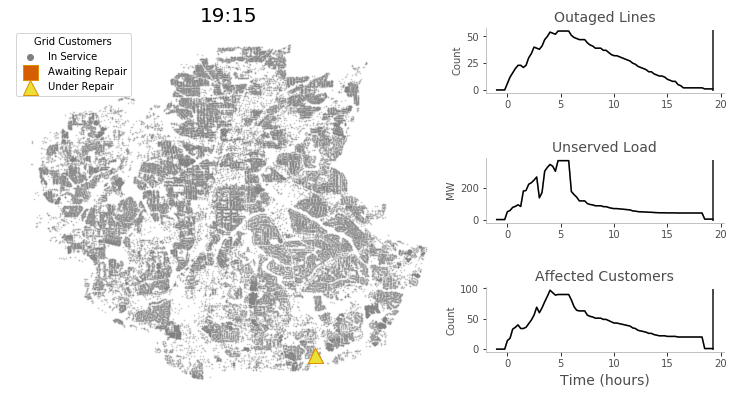

In [215]:
sim = 304

outages = pd.read_csv(os.path.join(simulations_dir, 'new_outage_tables', 'outages_simulation%i.csv'%(number)), index_col=0)
timeseries = pd.read_csv(os.path.join(simulations_dir, 'new_time_series', 'timeseries_simulation%i.csv'%(number)), index_col=0)

make_video(sim, outages, timeseries)

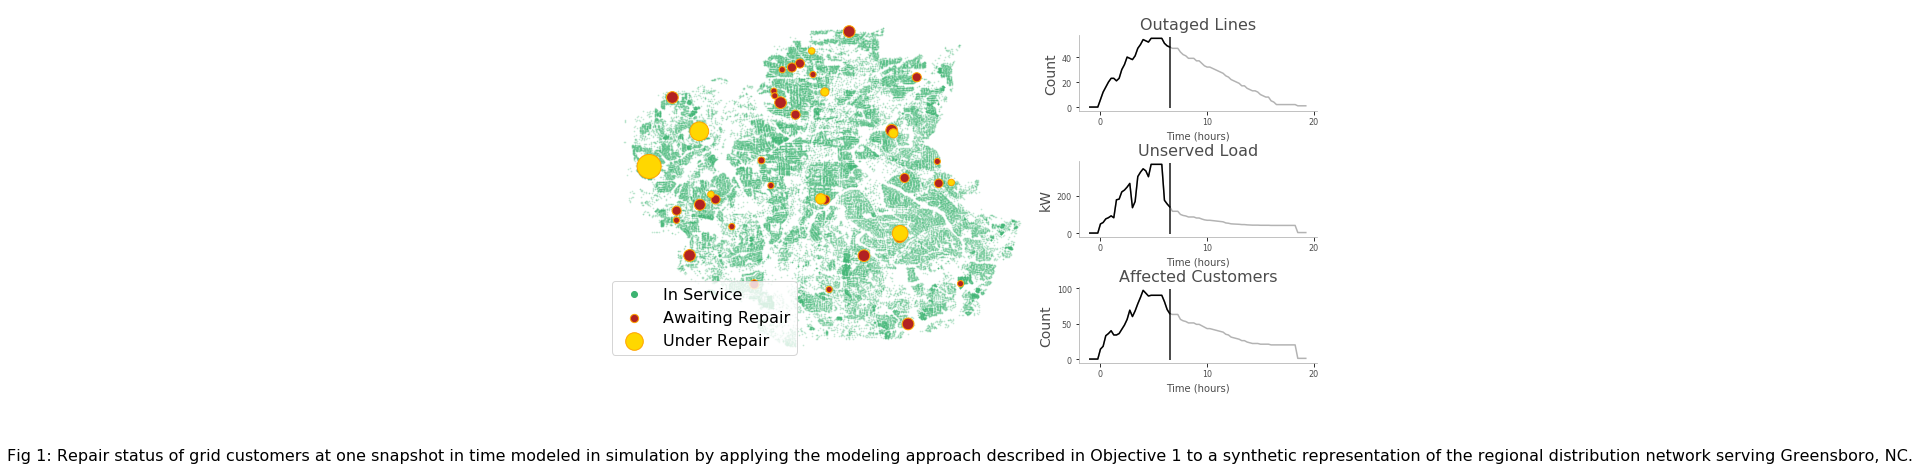

In [32]:
import seaborn as sns

Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

outColor = 'firebrick'#sns.color_palette()[3]
fixColor = 'gold'#sns.color_palette()[1]
onColor = 'mediumseagreen'

# edgeColor = sns.color_palette("colorblind", 12)[1]
# outColor = sns.color_palette("colorblind", 12)[3]
# fixColor = sns.color_palette("colorblind", 12)[8]
# onColor = sns.color_palette("colorblind", 12)[2]

def make_png(sim, outages, timeseries, i, subplots='right', size='big'):
    x_dist = system.network['bus_geodata']['x'].max()-system.network['bus_geodata']['x'].min()
    y_dist = system.network['bus_geodata']['y'].max()-system.network['bus_geodata']['y'].min()

    times = timeseries.index
    
    idxLoads = system.network['bus_geodata'].index.isin(system.network['load']['bus']) & (system.network['bus']['zone']=='Urban-Suburban')
#     idxLoads = system.network['bus_geodata'].index.isin(system.network['load']['bus'])
        
    
    if size == 'big':
        fontsizes = []
    elif size=='tiny':
        fontsizes = []
        
    if subplots=='right' and size=='big':
        fig = plt.figure(figsize=(11,7))
        ax1 = fig.add_axes([0.05,0.25,.55,.7])        
        ax2 = fig.add_axes([0.65,.75,.3,.15])
        ax3 = fig.add_axes([0.65,0.5,.3,.15])
        ax4 = fig.add_axes([0.65,0.25,.3,.15])

        ax2.set_xlabel('Time (hours)', color='0.3', fontsize=10)
        ax3.set_xlabel('Time (hours)', color='0.3', fontsize=10)
        ax4.set_xlabel('Time (hours)', color='0.3', fontsize=10)
        
    elif subplots=='below' and size=='big':
        pass
        
#     ax2 = fig.add_axes([0.1,0.3,.8,.08])
#     ax3 = fig.add_axes([0.1,0.2,.8,.08])
#     ax4 = fig.add_axes([0.1,0.1,.8,.08])

#     ax2 = fig.add_axes([0.1,.15,.2,.08])
#     ax3 = fig.add_axes([0.425,0.15,.2,.08])
#     ax4 = fig.add_axes([0.75,0.15,.2,.08])

#     ax2 = fig.add_axes([0.07,.15,.25,.1])
#     ax3 = fig.add_axes([0.38,0.15,.25,.1])
#     ax4 = fig.add_axes([0.7,0.15,.25,.1])
    
#     ax3.set_xlabel('Time (hours)', color='0.3', fontsize=14)
#     ax2 = fig.add_axes([0.65,.75,.3,.15])
#     ax3 = fig.add_axes([0.65,0.45,.3,.15])
#     ax4 = fig.add_axes([0.65,0.15,.3,.15])


#     fig = plt.figure(figsize=(5,4))
#     fig = plt.figure(figsize=(8,6))
    
#     ax1 = fig.add_axes([0.05,0.35,.9,.65])
#     ax1 = fig.add_axes([0.05,0.35,.9,.55])
#     ax1 = fig.add_axes([0.05,0.05,.55,.85])

    ax1.scatter(system.network['bus_geodata']['x'][idxLoads], system.network['bus_geodata']['y'][idxLoads], 
               marker='.', color=onColor, alpha=0.2, s=3, label=None)
    ax1.plot([], [], marker='o', color=onColor, ls=' ', label='In Service')
    
    xmin, xmax = ax1.get_xlim()
#     ax1.set_xlim(xmin-0.15*(xmax-xmin), xmax)

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)

#     lineOut, = ax1.plot([], [], ls=' ', marker='o', color=outColor, markeredgecolor=edgeColor, markeredgewidth=1, label='Awaiting Repair', markersize=15)
#     lineFix, = ax1.plot([], [], ls=' ', marker='o', color=fixColor, markeredgecolor=edgeColor, markeredgewidth=1, label='Under Repair', markersize=15)
    
    
    ax2.set_title('Outaged Lines', fontsize=16, color='0.3')
    ax2.set_ylabel('Count', color='0.3', fontsize=14)
    ax3.set_title('Unserved Load', fontsize=16, color='0.3')
    ax3.set_ylabel('kW', color='0.3', fontsize=14)
    ax4.set_title('Affected Customers', fontsize=16, color='0.3')
    ax4.set_ylabel('Count', color='0.3', fontsize=14)
    
#     ax2.set_xticks([x for x in timeseries.index if x%(5*60)==0])
#     ax2.set_xticklabels([int(x/60) for x in timeseries.index if x%(5*60)==0])

    ax2.set_xticks(np.arange(0,15*20*60+15,10*60))
    ax2.set_xticklabels(np.arange(0,21,10), fontsize=8)
    
    ax3.set_xticks(np.arange(0,15*20*60+15,10*60))
    ax3.set_xticklabels(np.arange(0,21,10), fontsize=8)
    
    ax4.set_xticks(np.arange(0,15*20*60+15,10*60))
    ax4.set_xticklabels(np.arange(0,21,10), fontsize=8)
    
    ylims = {}
    for key in timeseries.keys():
        ylims[key] = (0, timeseries[key].max())

    for _ax, key in zip([ax2,ax3,ax4],['Lines','Load (MW)','Customers']):
        _ax.tick_params(labelsize=8, labelcolor='0.3')

        _ax.spines['right'].set_visible(False)
        _ax.spines['top'].set_visible(False)
        _ax.spines['left'].set_color('0.7')
        _ax.spines['bottom'].set_color('0.7')
        
    key = 'Lines'
    ax2.plot(timeseries.index, timeseries[key], color='0.7', lw=1.5)
    vlines2, = ax2.plot([], [], color='0.3', lw=2)
    plines2, = ax2.plot([], [], color='k', lw=1.5)

    key = 'Load (MW)'
    ax3.plot(timeseries.index, timeseries[key], color='0.7', lw=1.5)
    vlines3, = ax3.plot([], [], color='0.3', lw=2)
    plines3, = ax3.plot([], [], color='k', lw=1.5)

    key = 'Customers'
    ax4.plot(timeseries.index, timeseries[key], color='0.7', lw=1.5)
    vlines4, = ax4.plot([], [], color='0.3', lw=2)
    plines4, = ax4.plot([], [], color='k', lw=1.5)

#     lineOut.set_data([], [])
#     lineFix.set_data([], [])

#     vlines2.set_data([], [])
#     vlines3.set_data([], [])
#     vlines4.set_data([], [])

#     plines2.set_data([], [])
#     plines3.set_data([], [])
#     plines4.set_data([], [])

    system.network['line']['in_service'] = True
        
    idxOut = (outages['start']<=times[i])&(outages['end']>times[i])
    if sum(idxOut) > 0:
        
        out = {'x': [], 'y': [], 's': []}
        fix = {'x': [], 'y': [], 's': []}
        for l in outages[idxOut].index:
            system.network['line']['in_service'].loc[l] = False
            unsupplied_busses = pp.topology.unsupplied_buses(system.network)
            unsupplied_busses = unsupplied_busses & set(system.network['bus'][system.network['bus']['zone']=='Urban-Suburban'].index)
            system.network['line']['in_service'] = True
            
            if outages['end'].loc[l]-outages['repair_time'].loc[l]<=times[i]:
                fix['x'].append(np.average(system.network['bus_geodata']['x'].loc[unsupplied_busses]))
                fix['y'].append(np.average(system.network['bus_geodata']['y'].loc[unsupplied_busses]))
                fix['s'].append(15*system.network['load']['p_kw'].loc[system.network['load']['bus'].isin(unsupplied_busses)].sum())
            else:
                out['x'].append(np.average(system.network['bus_geodata']['x'].loc[unsupplied_busses]))
                out['y'].append(np.average(system.network['bus_geodata']['y'].loc[unsupplied_busses]))
                out['s'].append(50*system.network['load']['p_kw'].loc[system.network['load']['bus'].isin(unsupplied_busses)].sum())
                
        ax1.scatter(out['x'], out['y'], out['s'], edgecolor='orange', color=outColor, label='Awaiting Repair')
        ax1.scatter(fix['x'], fix['y'], fix['s'], edgecolor='orange', color=fixColor, label='Under Repair')
        
    ax1.legend(loc=3, fontsize=16)
#         idxFix = idxOut & ((outages['end']-outages['repair_time'])<=times[i])

#         system.network['line']['in_service'].loc[outages[idxFix].index] = False
#         inrepair_busses = pp.topology.unsupplied_buses(system.network)
#         system.network['line']['in_service'] = True

#         x = system.network['bus_geodata']['x'].loc[unsupplied_busses-inrepair_busses]
#         y = system.network['bus_geodata']['y'].loc[unsupplied_busses-inrepair_busses]
#         lineOut.set_data(x, y)


#         x = system.network['bus_geodata']['x'].loc[inrepair_busses]
#         y = system.network['bus_geodata']['y'].loc[inrepair_busses]
#         lineFix.set_data(x, y)

    key = 'Lines'
    vlines2.set_data([times[i], times[i]], ylims[key])
    plines2.set_data(times[:i+1], timeseries[key].loc[times[:i+1]])

    key = 'Load (MW)'
    vlines3.set_data([times[i], times[i]], ylims[key])
    plines3.set_data(times[:i+1], timeseries[key].loc[times[:i+1]])

    key = 'Customers'
    vlines4.set_data([times[i], times[i]], ylims[key])
    plines4.set_data(times[:i+1], timeseries[key].loc[times[:i+1]])

    if times[i]<0:
        title='-%s:%s'%(str(int(times[i]/60)).zfill(2), str(int(times[i]%60)).zfill(2))
    else:
        title='%s:%s'%(str(int(times[i]/60)).zfill(2), str(int(times[i]%60)).zfill(2))

#     ax1.set_title(title, fontsize=20)
    ax5 = fig.add_axes([0.1,0.05,0.8,0.1])
    ax5.text(0.5, 0, 'Fig 1: Repair status of grid customers at one snapshot in time modeled in simulation by applying the modeling approach described in Objective 1 to a synthetic representation of the regional distribution network serving Greensboro, NC.',
            ha='center', va='bottom', fontsize=16, wrap=True)
    ax5.set_frame_on(False)
    ax5.set_xticks([])
    ax5.set_yticks([])

    
    fig.savefig('figures/poster/snapshot.png')

sim = 304

outages = pd.read_csv(os.path.join(simulations_dir, 'new_outage_tables', 'outages_simulation%i.csv'%(number)), index_col=0)
timeseries = pd.read_csv(os.path.join(simulations_dir, 'new_time_series', 'timeseries_simulation%i.csv'%(number)), index_col=0)

make_png(sim, outages, timeseries, 30)
plt.show()